In [1]:
from dotenv import load_dotenv
load_dotenv('values.env')
from langsmith import traceable

In [7]:
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from langchain.tools import tool
from langchain_core.tools import tool
import os.path
import pickle
from typing import Optional

SCOPES = ['https://www.googleapis.com/auth/calendar']

@traceable
def get_calendar_service():
    """Authenticate and return calendar service."""
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'client_secret_961240229011-6vncaf9dgjrre9k9no49l18h7v5k91a5.apps.googleusercontent.com.json', SCOPES)
            creds = flow.run_local_server(port=0)
        
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    
    return build('calendar', 'v3', credentials=creds)

@tool
@traceable
def list_calendars() -> str:
    """
    List all available Google calendars.
    
    Returns:
    
        List of calendar names and IDs
    """
    try:
        service = get_calendar_service()
        calendars = service.calendarList().list().execute()
        
        result = "Available calendars:\n"
        for cal in calendars.get('items', []):
            result += f"- {cal['summary']} (ID: {cal['id']})\n"
        return result
    except Exception as e:
        return f"Error listing calendars: {str(e)}"

@tool
@traceable
def create_calendar_event(
    summary: str,
    start_time: str,
    end_time: str,
    calendar_id: str = "primary",
    description: Optional[str] = None,
    location: Optional[str] = None,
    timezone: str = "America/New_York"
) -> str:
    """
    Create a Google Calendar event.
    
    Args:
        summary: Event title
        start_time: Start time in ISO 8601 format (e.g., '2025-10-15T10:00:00')
        end_time: End time in ISO 8601 format (e.g., '2025-10-15T11:00:00')
        calendar_id: Calendar ID (the appropriate calendar ID to add the event to)
        description: Event description (optional)
        location: Event location (optional)
        timezone: Timezone (default: America/New_York)
    
    Returns:
        Success message with event link
    """
    try:
        service = get_calendar_service()
        
        event = {
            'summary': summary,
            'start': {
                'dateTime': start_time,
                'timeZone': timezone,
            },
            'end': {
                'dateTime': end_time,
                'timeZone': timezone,
            },
        }
        
        if description:
            event['description'] = description
        if location:
            event['location'] = location
        
        created_event = service.events().insert(calendarId=calendar_id, body=event).execute()
        return f"Event created successfully: {created_event.get('htmlLink')}"
    except Exception as e:
        return f"Error creating event: {str(e)}"



In [9]:
tools=[list_calendars, create_calendar_event]
tools_by_name={ tool.name:tool for tool in tools}

In [8]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    base_url="https://81db01e1b163.ngrok-free.app/v1",
    model="qwen/qwen3-4b-2507",
    api_key="Doesn't need one" # type: ignore
)

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a helpful AI assistant that thinks step-by-step and uses tools when needed.

When responding to queries:
1. First, think about what information you need
2. Use available tools if you need current data or specific capabilities  
3. Provide clear, helpful responses based on your reasoning and any tool results

Always explain your thinking process to help users understand your approach.
"""),
    MessagesPlaceholder(variable_name="scratch_pad")
])

In [11]:
model_react=chat_prompt | model.bind_tools(tools)

In [12]:
from typing import (Annotated,Sequence,TypedDict)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [13]:
@traceable
def tool_node(state: AgentState):
    """Execute all tool calls from the last message in the state."""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

In [14]:
@traceable
def call_model(state: AgentState):
    """Invoke the model with the current conversation state."""
    response = model_react.invoke({"scratch_pad": state["messages"]})
    return {"messages": [response]}

In [15]:
@traceable
def should_continue(state: AgentState):
    """Determine whether to continue with tool use or end the conversation."""
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if last_message.tool_calls:
        return "continue"
    # Otherwise if there is, we continue
    else:
        return "end"

In [17]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent_node", call_model)
workflow.add_node("tools_node", tool_node)
    
# Add edges between nodes
workflow.add_edge("tools_node", "agent_node")  # After tools, always go back to agent

# Add conditional logic
workflow.add_conditional_edges(
    "agent_node",
    should_continue,
    {
        "continue": "tools_node",  # If tools needed, go to tools node
        "end": END,          # If done, end the conversation
    },
)

# Set entry point
workflow.set_entry_point("agent_node")

# Compile the graph
graph = workflow.compile()

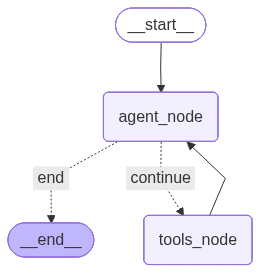

In [18]:
graph

In [19]:
@traceable
def print_stream(stream):
    """Helper function for formatting the stream nicely."""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


In [20]:
@traceable
def run_agent():    
    inputs = {"messages": [HumanMessage(content="Add an exam to my calendar tomorrow at 10am")]}
    print_stream(graph.stream(inputs, stream_mode="values"))

In [ ]:
run_agent()